# Clustering Analysis of Features

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes

## K-Means Clustering

K-Means clustering is based on Euclidean distance, so scaling the features beforehand is necessary to prevent variables with larger ranges from taking over the clustering process.

In [17]:
# clustering profiles based on top 3 features
df = pd.read_csv("data\cleaned_insurance_log_transformed.csv")
target_col = "log_charges"

X = df.drop(columns=[target_col, "charges"])
y = df[target_col]


top_features = ['smoker', 'bmi', 'age']
X_cluster = X[top_features]
X_cluster.head()

,smoker,bmi,age
0,1,27.900,19
1,0,33.770,18
2,0,33.000,28
3,0,22.705,33
4,0,28.880,32


<Figure size 700x500 with 0 Axes>

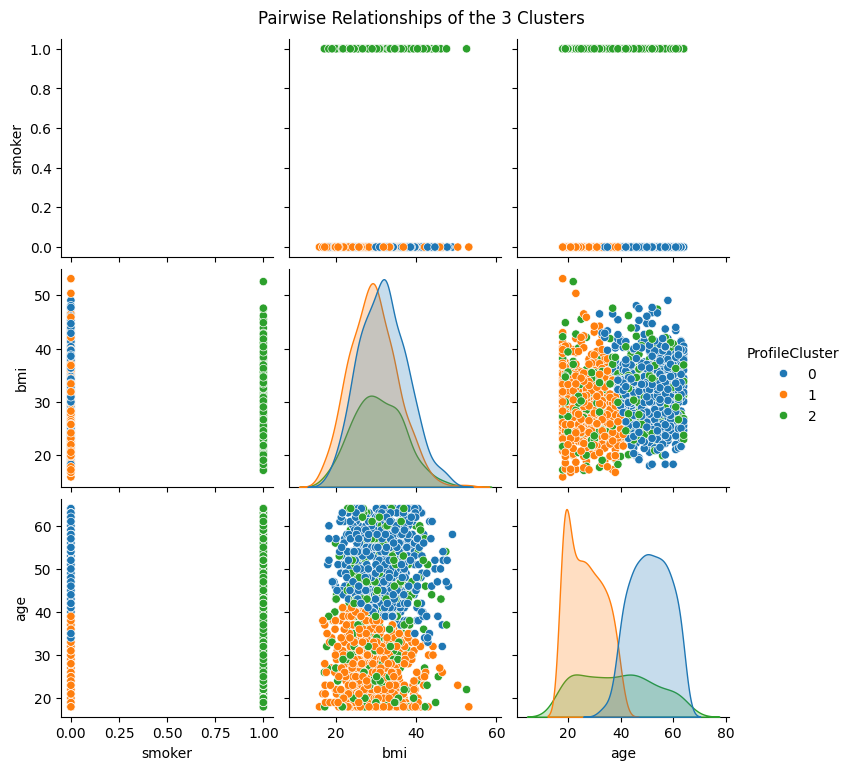

In [18]:
# in order to use k-means clustering, there needs to be a scaling of the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=0)
df['ProfileCluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7,5))
sns.pairplot(df, vars=top_features, hue='ProfileCluster', palette='tab10')
plt.suptitle("Pairwise Relationships of the 3 Clusters", y=1.02)
plt.show()

From the plot above, we notice that the BMI variable doesn't separate clealy across the clusters, there is a clear overlap in the BMI variable. It's possible that the BMI distribution is continuous and smooth, which would make it hard to detect a natural grouping pattern. BMI does not distinguish naturally occurring patient profiles in this dataset.

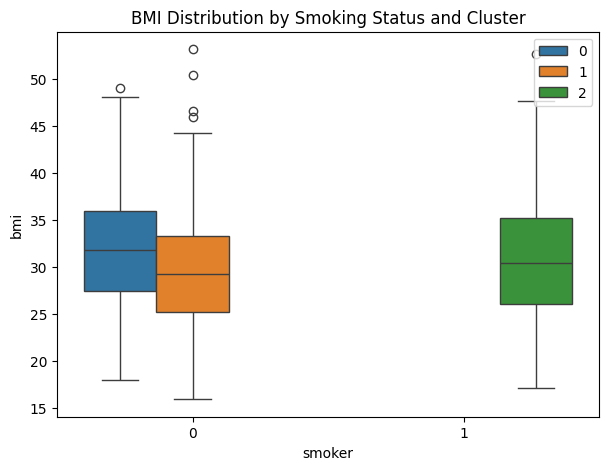

In [7]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='smoker', y='bmi', hue='ProfileCluster', palette='tab10')
plt.title("BMI Distribution by Smoking Status and Cluster")
plt.legend(loc='upper right')
plt.show()

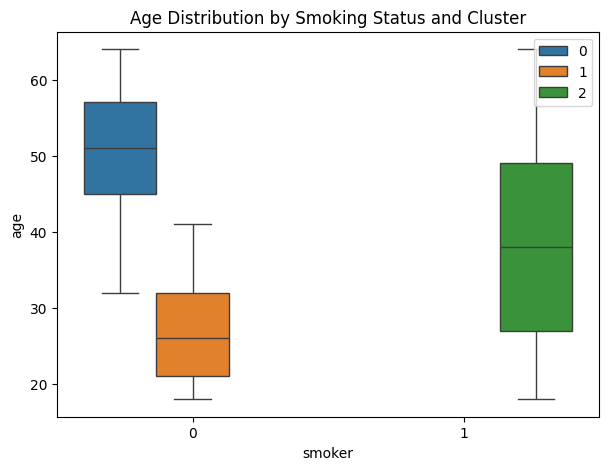

In [8]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='smoker', y='age', hue='ProfileCluster', palette='tab10')
plt.title("Age Distribution by Smoking Status and Cluster")
plt.legend(loc='upper right')
plt.show()

In [19]:
# summary by cluster
cluster_summary = df.groupby('ProfileCluster')[[target_col]].mean()
print("Average Loss per Cluster:")
display(cluster_summary)

Average Loss per Cluster:


,log_charges
ProfileCluster,
0,9.284006
1,8.261713
2,10.304110


In [22]:
# Summary statistics for each cluster
cluster_summary = df.groupby("ProfileCluster").agg({
    "age": ["mean", "median"],
    "bmi": ["mean", "median"],
    "children": "mean",
    "smoker": "mean",
    "sex": "mean",
    "log_charges": ["mean", "median"],})

cluster_summary

age               bmi           children smoker  \
                     mean median       mean   median      mean   mean   
ProfileCluster                                                          
0               51.222628   51.0  31.799361  31.8125  1.129562    0.0   
1               26.813953   26.0  29.433062  29.2600  1.048450    0.0   
2               38.514599   38.0  30.708449  30.4475  1.113139    1.0   

                     sex log_charges             
                    mean        mean     median  
ProfileCluster                                   
0               0.479927    9.284006   9.266569  
1               0.492248    8.261713   8.266599  
2               0.580292   10.304110  10.447448

## Gaussian Mixture Model clustering

Text(0.5, 1.0, 'PCA of Patient Features with Clusters')

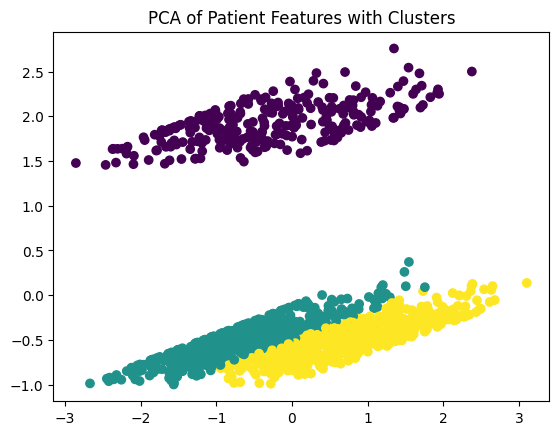

In [ ]:
gmm = GaussianMixture(n_components=3).fit(X_scaled)
labels = gmm.predict(X_scaled)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
plt.scatter(pc[:,0], pc[:,1], c=labels)
plt.title("PCA of Patient Features with Clusters")

It seems like GMM is better at capturing underlying interactions between variables that K-Means probably missed. The three clusters appear clearly separated and don't overlap. We can determine from this that smokers form their own groupings that drive hospital log-charges, age forms a spectrum, and BMI contributes but does not dominate the interaction between log-charges. The diagonal direction of the clusters suggest some interaction effects between variables differentiate groups rather than individual variables alone.

## K-Modes clustering

The presence of binary (factors) features makes K-Means Clustering not appropriate for a task like this. Instead, we can use K-Prototypes Clustering, which uses Euclidean distance for continuous variables, but uses dissimilarity for categorical variables.

               age       sex        bmi  children    smoker       charges  \
Cluster                                                                     
0        39.757075  0.504717  30.487064  1.462264  0.231132  13291.088726   
1        23.458774  0.515856  29.846892  0.873150  0.213531   9482.262172   
2        55.569161  0.494331  31.708685  0.979592  0.170068  17313.590394   

         region_northwest  region_southeast  region_southwest  log_charges  \
Cluster                                                                      
0                0.238208          0.275943          0.247642     9.205285   
1                0.245243          0.274841          0.236786     8.528476   
2                0.244898          0.265306          0.244898     9.607699   

         ProfileCluster  
Cluster                  
0              0.801887  
1              1.213531  
2              0.340136  
         sex  smoker  region_northwest  region_southeast  region_southwest
Cluster           

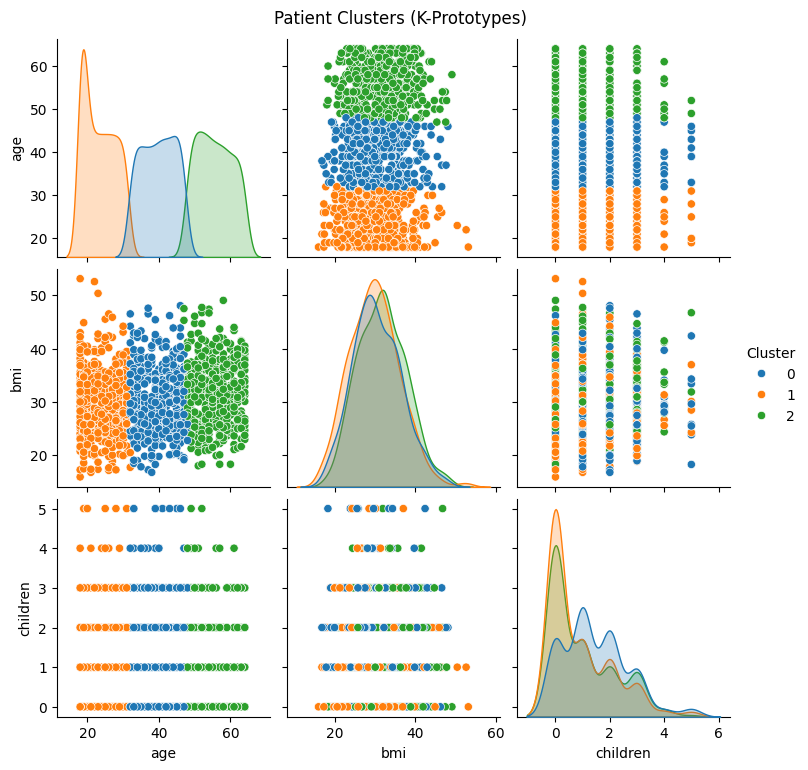

In [10]:
categorical_columns = ['sex', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']

X_matrix = df.drop(columns=["log_charges", "charges"]).to_numpy()

# Find indices of categorical columns
cat_indices = [df.columns.get_loc(col) for col in categorical_columns]

# Initialize and fit K-Prototypes
kproto = KPrototypes(n_clusters=3, init='Huang', random_state=0)
clusters = kproto.fit_predict(X_matrix, categorical=cat_indices)

df['Cluster'] = clusters
print(df.groupby('Cluster').mean(numeric_only=True))
print(df.groupby('Cluster')[categorical_columns].agg(lambda x: x.value_counts().index[0]))

sns.pairplot(df, vars=['age', 'bmi', 'children'], hue='Cluster', palette='tab10')
plt.suptitle("Patient Clusters (K-Prototypes)", y=1.02)
plt.show()

In [11]:
# Analysis of the cluster centroids
display(kproto.cluster_centroids_)

array([[39.75707547, 30.48706368,  1.46226415,  0.23820755,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [23.45877378, 29.84689218,  0.87315011,  0.24524313,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [55.569161  , 31.70868481,  0.97959184,  0.24489796,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

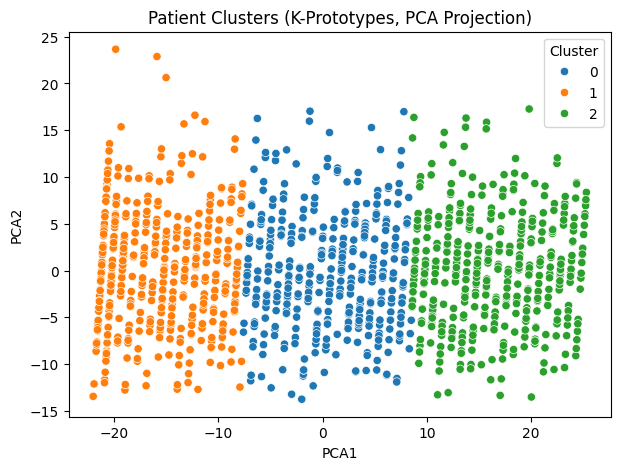

In [ ]:
from sklearn.decomposition import PCA

X_num = df[['age', 'bmi', 'children']]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_num)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("Patient Clusters (K-Prototypes, PCA Projection)")
plt.show()